In [ ]:
# default_exp data.preparation

# Data preparation

> Functions required to prepare X (and y) from a pandas dataframe.

In [ ]:
#export
from tsai.imports import *
from tsai.utils import *
from tsai.data.validation import *

In [ ]:
#export
def df2Xy(df, sample_col=None, feat_col=None, data_cols=None, target_col=None, to3d=True, splits=None, sort_by=None, ascending=True, y_func=None):
    r"""
    This function allows you to transform a pandas dataframe into X and y numpy arrays that can be used to craete a TSDataset.
    sample_col: column that uniquely identifies each sample.
    feat_col: used for multivariate datasets. It indicates which is the column that indicates the feature by row.
    data_col: indicates ths column/s where the data is located. If None, it means all columns (except the sample_col, feat_col, and target_col)
    target_col: indicates the column/s where the target is.
    to3d: turns X to 3d (including univariate time series)
    sort_by: used to indicate how to sort the dataframe.
    y_func: function used to calculate y for each sample (and target_col)
    """
    if feat_col is not None:
        assert sample_col is not None, 'You must pass a sample_col when you pass a feat_col'

    passed_cols = []
    sort_cols = []
    if sort_by is not None:
        if isinstance(sort_by, pd.core.indexes.base.Index): sort_by = sort_by.tolist()
        sort_cols += listify(sort_by)
    if sample_col is not None:
        if isinstance(sample_col, pd.core.indexes.base.Index): sample_col = sample_col.tolist()
        sample_col = listify(sample_col)
        sort_cols += listify(sample_col)
        passed_cols += sample_col
    if feat_col is not None:
        if isinstance(feat_col, pd.core.indexes.base.Index): feat_col = feat_col.tolist()
        feat_col = listify(feat_col)
        sort_cols += listify(feat_col)
        passed_cols += feat_col
    if data_cols is not None:
        if isinstance(data_cols, pd.core.indexes.base.Index): data_cols = data_cols.tolist()
        data_cols = listify(data_cols)
    if target_col is not None:
        if isinstance(target_col, pd.core.indexes.base.Index): target_col = target_col.tolist()
        target_col = listify(target_col)
        passed_cols += target_col

    if data_cols is None:
        data_cols = [col for col in df.columns if col not in passed_cols]
    if sort_cols:
        df.sort_values(sort_cols, ascending=ascending, inplace=True)

    # X
    X = df.loc[:, data_cols].values
    if X.dtype == 'O':
        X = X.astype(np.float32)
    if sample_col is not None:
        unique_ids = df[sample_col[0]].unique().tolist()
        n_samples = len(unique_ids)
    else:
        unique_ids = np.arange(len(df)).tolist()
        n_samples = len(df)
    if feat_col is not None:
        n_feats = df[feat_col[0]].nunique()
        X = X.reshape(n_samples, n_feats, -1)
    elif to3d:
        X = X.reshape(n_samples, 1, -1)

    # y
    if target_col is not None:
        if sample_col is not None: 
            y = []
            for tc in target_col:
                _y = np.concatenate(df.groupby(sample_col)[tc].apply(np.array).reset_index()[tc]).reshape(n_samples, -1)
                if y_func is not None: _y = y_func(_y)
                y.append(_y)
            y = np.concatenate(y, -1)
        else: 
            y = df[target_col].values
        y = np.squeeze(y)
    else:
        y = None

    # Output
    if splits is None: return X, y
    else: return split_xy(X, y, splits)
    

def split_Xy(X, y=None, splits=None):
    if splits is None: 
        if y is not None: return X, y
        else: return X
    if not is_listy(splits[0]): splits = [splits]
    else: assert not is_listy(splits[0][0]), 'You must pass a single set of splits.'
    _X = []
    _y = []
    for split in splits:
        _X.append(X[split])
        if y is not None: _y.append(y[split])
    if len(splits) == 1: return _X[0], _y[0]
    elif len(splits) == 2: return _X[0], _y[0], _X[1], _y[1]
    elif len(splits) == 3: return _X[0], _y[0], _X[1], _y[1], _X[2], _y[2]
    
df2xy = df2Xy
split_xy = split_Xy

In [ ]:
n_samples = 1_000
n_rows = 10_000

sample_ids = np.arange(n_samples).repeat(n_rows//n_samples).reshape(-1,1)
feat_ids = np.tile(np.arange(n_rows // n_samples), n_samples).reshape(-1,1)
cont = np.random.randn(n_rows, 6)
ind_cat = np.random.randint(0, 3, (n_rows, 1))
target = np.array(['a', 'b', 'c'])[ind_cat]
ind_cat2 = np.random.randint(0, 3, (n_rows, 1))
target2 = np.array(['a', 'b', 'c'])[ind_cat2]
data = np.concatenate([sample_ids, feat_ids, cont, target, target], -1)
columns = ['sample_id', 'feat_id'] + (np.arange(6) + 1).astype(str).tolist() + ['target'] + ['target2']
df = pd.DataFrame(data, columns=columns)
idx = np.random.choice(np.arange(len(df)), len(df), False)
new_dtypes = {'sample_id':np.int32, 'feat_id':np.int32, '1':np.float32, '2':np.float32, '3':np.float32, '4':np.float32, '5':np.float32, '6':np.float32}
df = df.astype(dtype=new_dtypes)
df = df.loc[idx].reset_index(drop=True)
df

,sample_id,feat_id,1,2,3,4,5,6,target,target2
0,947,4,0.304183,0.761778,0.727974,-0.337132,0.863938,0.592976,a,a
1,828,0,0.292987,-0.090154,-1.735314,1.413636,-0.074045,-0.048356,c,c
2,650,0,0.357920,0.710721,0.171866,1.616276,0.414450,-0.493871,c,c
3,210,2,-1.193618,-1.317021,-0.161434,1.004269,-3.793914,0.301594,a,a
4,801,7,0.265836,0.266801,-1.272071,-0.215930,2.090459,-0.356132,b,b
...,...,...,...,...,...,...,...,...,...,...
9995,421,0,0.324470,-1.612018,2.459636,1.083316,-0.695845,-0.757040,b,b
9996,300,5,-0.851891,1.702319,-1.166702,0.656939,-0.953500,0.653456,a,a
9997,29,7,-0.637562,-0.834099,-0.445675,0.030869,-1.925938,1.202756,c,c
9998,37,7,-1.927830,0.407021,1.456804,0.208396,-0.447580,-1.286960,a,a


In [ ]:
def y_func(o): return scipy.stats.mode(o, axis=1).mode
X, y = df2xy(df, sample_col='sample_id', feat_col='feat_id', data_cols=['1', '2', '3', '4', '5', '6'], target_col=['target'], y_func=y_func)
test_eq(X.shape, (1000, 10, 6))
test_eq(y.shape, (1000,))
rand_idx = np.random.randint(0, np.max(df.sample_id))
sorted_df = df.sort_values(by=['sample_id', 'feat_id']).reset_index(drop=True)
test_eq(X[rand_idx], sorted_df[sorted_df.sample_id == rand_idx][['1', '2', '3', '4', '5', '6']].values)
test_eq(np.squeeze(scipy.stats.mode(sorted_df[sorted_df.sample_id == rand_idx][['target']].values).mode), y[rand_idx])

In [ ]:
def y_func(o): return scipy.stats.mode(o, axis=1).mode
X, y = df2xy(df, sample_col='sample_id', feat_col='feat_id', target_col=['target', 'target2'], y_func=y_func)
test_eq(X.shape, (1000, 10, 6))
test_eq(y.shape, (1000, 2))
rand_idx = np.random.randint(0, np.max(df.sample_id))
sorted_df = df.sort_values(by=['sample_id', 'feat_id']).reset_index(drop=True)
test_eq(X[rand_idx], sorted_df[sorted_df.sample_id == rand_idx][['1', '2', '3', '4', '5', '6']].values)
test_eq(np.squeeze(scipy.stats.mode(sorted_df[sorted_df.sample_id == rand_idx][['target', 'target2']].values).mode), y[rand_idx])

In [ ]:
# Univariate
from io import StringIO
TESTDATA = StringIO("""sample_id;value_0;value_1;target
    rob;2;3;hot
    alice;6;7;lukewarm
    eve;11;12;cold
    """)

df = pd.read_csv(TESTDATA, sep=";")
display(df)
X, y = df2Xy(df, sample_col='sample_id', target_col='target', data_cols=['value_0', 'value_1'], sort_by='sample_id')
test_eq(X.shape, (3, 1, 2))
test_eq(y.shape, (3,))
X, y

,sample_id,value_0,value_1,target
0,rob,2,3,hot
1,alice,6,7,lukewarm
2,eve,11,12,cold


(array([[[ 6,  7]],
 
        [[11, 12]],
 
        [[ 2,  3]]]),
 array(['lukewarm', 'cold', 'hot'], dtype=object))

In [ ]:
# Univariate
TESTDATA = StringIO("""sample_id;timestep;values;target
    rob;1;2;hot
    alice;1;6;lukewarm
    eve;1;11;cold
    
    rob;2;3;hot
    alice;2;7;lukewarm
    eve;2;12;cold
    """)

df = pd.read_csv(TESTDATA, sep=";")
display(df)
def y_func(o): return scipy.stats.mode(o, axis=1).mode
X, y = df2xy(df, sample_col='sample_id', target_col='target', data_cols=['values'], sort_by='timestep', to3d=True, y_func=y_func)
test_eq(X.shape, (3, 1, 2))
test_eq(y.shape, (3, ))
print(X, y)

,sample_id,timestep,values,target
0,rob,1,2,hot
1,alice,1,6,lukewarm
2,eve,1,11,cold
3,rob,2,3,hot
4,alice,2,7,lukewarm
5,eve,2,12,cold


[[[ 6 11]]

 [[ 2  7]]

 [[12  3]]] ['lukewarm' 'cold' 'hot']


In [ ]:
# Multivariate
TESTDATA = StringIO("""sample_id;trait;value_0;value_1;target
    rob;green;2;3;hot
    rob;yellow;3;4;hot
    rob;blue;4;5;hot
    rob;red;5;6;hot
    alice;green;6;7;lukewarm
    alice;yellow;7;8;lukewarm
    alice;blue;8;9;lukewarm
    alice;red;9;10;lukewarm
    eve;yellow;11;12;cold
    eve;green;10;11;cold
    eve;blue;12;12;cold
    eve;red;13;14;cold
    """)

df = pd.read_csv(TESTDATA, sep=";")
idx = np.random.choice(len(df), len(df), False)
df = df.iloc[idx]
display(df)
def y_func(o): return scipy.stats.mode(o, axis=1).mode
X, y = df2xy(df, sample_col='sample_id', feat_col='trait', target_col='target', data_cols=['value_0', 'value_1'], y_func=y_func)
print(X, y)
test_eq(X.shape, (3, 4, 2))
test_eq(y.shape, (3,))

,sample_id,trait,value_0,value_1,target
1,rob,yellow,3,4,hot
0,rob,green,2,3,hot
4,alice,green,6,7,lukewarm
2,rob,blue,4,5,hot
8,eve,yellow,11,12,cold
3,rob,red,5,6,hot
10,eve,blue,12,12,cold
9,eve,green,10,11,cold
5,alice,yellow,7,8,lukewarm
11,eve,red,13,14,cold


[[[ 8  9]
  [ 6  7]
  [ 9 10]
  [ 7  8]]

 [[12 12]
  [10 11]
  [13 14]
  [11 12]]

 [[ 4  5]
  [ 2  3]
  [ 5  6]
  [ 3  4]]] ['lukewarm' 'cold' 'hot']


In [ ]:
# Multivariate, multi-label
TESTDATA = StringIO("""sample_id;trait;value_0;value_1;target1;target2
    rob;green;2;3;hot;good
    rob;yellow;3;4;hot;good
    rob;blue;4;5;hot;good
    rob;red;5;6;hot;good
    alice;green;6;7;lukewarm;good
    alice;yellow;7;8;lukewarm;good
    alice;blue;8;9;lukewarm;good
    alice;red;9;10;lukewarm;good
    eve;yellow;11;12;cold;bad
    eve;green;10;11;cold;bad
    eve;blue;12;12;cold;bad
    eve;red;13;14;cold;bad
    """)

df = pd.read_csv(TESTDATA, sep=";")
display(df)
def y_func(o): return scipy.stats.mode(o, axis=1).mode
X, y = df2xy(df, sample_col='sample_id', feat_col='trait', target_col=['target1', 'target2'], data_cols=['value_0', 'value_1'], y_func=y_func)
test_eq(X.shape, (3, 4, 2))
test_eq(y.shape, (3, 2))
print(X, y)

,sample_id,trait,value_0,value_1,target1,target2
0,rob,green,2,3,hot,good
1,rob,yellow,3,4,hot,good
2,rob,blue,4,5,hot,good
3,rob,red,5,6,hot,good
4,alice,green,6,7,lukewarm,good
5,alice,yellow,7,8,lukewarm,good
6,alice,blue,8,9,lukewarm,good
7,alice,red,9,10,lukewarm,good
8,eve,yellow,11,12,cold,bad
9,eve,green,10,11,cold,bad


[[[ 8  9]
  [ 6  7]
  [ 9 10]
  [ 7  8]]

 [[12 12]
  [10 11]
  [13 14]
  [11 12]]

 [[ 4  5]
  [ 2  3]
  [ 5  6]
  [ 3  4]]] [['lukewarm' 'good']
 ['cold' 'bad']
 ['hot' 'good']]


In [ ]:
# Multivariate, unlabeled
TESTDATA = StringIO("""sample_id;trait;value_0;value_1;target
    rob;green;2;3;hot
    rob;yellow;3;4;hot
    rob;blue;4;5;hot
    rob;red;5;6;hot
    alice;green;6;7;lukewarm
    alice;yellow;7;8;lukewarm
    alice;blue;8;9;lukewarm
    alice;red;9;10;lukewarm
    eve;yellow;11;12;cold
    eve;green;10;11;cold
    eve;blue;12;12;cold
    eve;red;13;14;cold
    """)

df = pd.read_csv(TESTDATA, sep=";")
idx = np.random.choice(len(df), len(df), False)
df = df.iloc[idx]
display(df)
def y_func(o): return scipy.stats.mode(o, axis=1).mode
X, y = df2xy(df, sample_col='sample_id', feat_col='trait', data_cols=['value_0', 'value_1'], y_func=y_func)
print(X, y)
test_eq(X.shape, (3, 4, 2))
test_eq(y, None)

,sample_id,trait,value_0,value_1,target
11,eve,red,13,14,cold
8,eve,yellow,11,12,cold
10,eve,blue,12,12,cold
9,eve,green,10,11,cold
2,rob,blue,4,5,hot
7,alice,red,9,10,lukewarm
5,alice,yellow,7,8,lukewarm
6,alice,blue,8,9,lukewarm
0,rob,green,2,3,hot
3,rob,red,5,6,hot


[[[ 8  9]
  [ 6  7]
  [ 9 10]
  [ 7  8]]

 [[12 12]
  [10 11]
  [13 14]
  [11 12]]

 [[ 4  5]
  [ 2  3]
  [ 5  6]
  [ 3  4]]] None


In [ ]:
TESTDATA = StringIO("""sample_id;trait;timestep;values;target
    rob;green;1;2;hot
    rob;yellow;1;3;hot
    rob;blue;1;4;hot
    rob;red;1;5;hot
    alice;green;1;6;lukewarm
    alice;yellow;1;7;lukewarm
    alice;blue;1;8;lukewarm
    alice;red;1;9;lukewarm
    eve;yellow;1;11;cold
    eve;green;1;10;cold
    eve;blue;1;12;cold
    eve;red;1;13;cold
    
    rob;green;2;3;hot
    rob;yellow;2;4;hot
    rob;blue;2;5;hot
    rob;red;2;6;hot
    alice;green;2;7;lukewarm
    alice;yellow;2;8;lukewarm
    alice;blue;2;9;lukewarm
    alice;red;2;10;lukewarm
    eve;yellow;2;12;cold
    eve;green;2;11;cold
    eve;blue;2;13;cold
    eve;red;2;14;cold
    """)

df = pd.read_csv(TESTDATA, sep=";")
display(df)
def y_func(o): return scipy.stats.mode(o, axis=1).mode
X, y = df2xy(df, sample_col='sample_id', feat_col='trait', sort_by='timestep', target_col='target', data_cols=['values'], y_func=y_func)
print(X, y)
test_eq(X.shape, (3, 4, 2))
test_eq(y.shape, (3, ))

,sample_id,trait,timestep,values,target
0,rob,green,1,2,hot
1,rob,yellow,1,3,hot
2,rob,blue,1,4,hot
3,rob,red,1,5,hot
4,alice,green,1,6,lukewarm
5,alice,yellow,1,7,lukewarm
6,alice,blue,1,8,lukewarm
7,alice,red,1,9,lukewarm
8,eve,yellow,1,11,cold
9,eve,green,1,10,cold


[[[ 8  6]
  [ 9  7]
  [12 10]
  [13 11]]

 [[ 4  2]
  [ 5  3]
  [ 9  7]
  [10  8]]

 [[13 11]
  [14 12]
  [ 5  3]
  [ 6  4]]] ['lukewarm' 'cold' 'hot']


In [ ]:
# export
def df2np3d(df, groupby, data_cols=None):
    """Transforms a df (with the same number of rows per group in groupby) to a 3d ndarray"""
    if data_cols is None: data_cols = df.columns
    return np.stack([x[data_cols].values for _, x in df.groupby(groupby)]).transpose(0, 2, 1)

In [ ]:
user = np.array([1,2]).repeat(4).reshape(-1,1)
val = np.random.rand(8, 3)
data = np.concatenate([user, val], axis=-1)
df = pd.DataFrame(data, columns=['user', 'x1', 'x2', 'x3'])
test_eq(df2np3d(df, ['user'], ['x1', 'x2', 'x3']).shape, (2, 3, 4))

In [ ]:
# export
def add_missing_value_cols(df, cols=None, dtype=float):
    if cols is None: cols = df.columns
    elif not is_listy(cols): cols = [cols]
    for col in cols:
        df[f'missing_{col}'] = df[col].isnull().astype(dtype)
    return df

In [ ]:
data = np.random.randn(10, 2)
mask = data > .8
data[mask] = np.nan
df = pd.DataFrame(data, columns=['A', 'B'])
df = add_missing_value_cols(df, cols=None, dtype=float)
test_eq(df['A'].isnull().sum(), df['missing_A'].sum())
test_eq(df['B'].isnull().sum(), df['missing_B'].sum())
df

,A,B,missing_A,missing_B
0,-0.227136,0.279747,0.0,0.0
1,-1.519388,-0.339465,0.0,0.0
2,-0.001306,-0.371552,0.0,0.0
3,0.595474,-0.408438,0.0,0.0
4,0.411540,NaN,0.0,1.0
5,-0.883092,-0.062348,0.0,0.0
6,-0.898957,NaN,0.0,1.0
7,NaN,-0.785318,1.0,0.0
8,NaN,-1.446876,1.0,0.0
9,-2.110008,NaN,0.0,1.0


In [ ]:
# export
def add_missing_timestamps(df, datetime_col, groupby=None, fill_value=np.nan, range_by_group=True, freq=None):
    """Fills missing timestamps in a dataframe to a desired frequency
    Args:
        df:                      pandas DataFrame
        datetime_col:            column tha contains the datetime data
        groupby:                 column used to identify unique_ids
        fill_value:              values that will be insert where missing dates exist. Default:np.nan
        range_by_group:          if True, dates will be filled between min and max dates for each group. Otherwise, between the min and max dates in the df.
        freq:                    frequence used to fillin the missing datetime
    """
    if is_listy(datetime_col): 
        assert len(datetime_col) == 1, 'you can only pass a single datetime_col'
        datetime_col = datetime_col[0]
    dates = pd.date_range(df[datetime_col].min(), df[datetime_col].max(), freq=freq)
    cols = df.columns
    if groupby is not None:
        if is_listy(groupby): 
            assert len(groupby) == 1, 'you can only pass a single groupby'
            groupby = groupby[0]
        keys = df[groupby].unique()
        if range_by_group:
            # Fills missing dates between min and max for each unique id
            min_dates = df.groupby(groupby)[datetime_col].min()
            max_dates = df.groupby(groupby)[datetime_col].max()
            idx_tuples = flatten_list([[(d, key) for d in pd.date_range(min_date, max_date)] for min_date, max_date, key in zip(min_dates, max_dates, keys)])
            multi_idx = pd.MultiIndex.from_tuples(idx_tuples, names=[datetime_col, groupby])
            df = df.set_index([datetime_col, groupby]).reindex(multi_idx, fill_value=np.nan).reset_index()
        else:
            # Fills missing dates between min and max - same for all unique ids
            multi_idx = pd.MultiIndex.from_product((dates, keys), names=[datetime_col, groupby])
            df = df.set_index([datetime_col, groupby]).reindex(multi_idx, fill_value=np.nan)
            df = df.reset_index().sort_values(by=[groupby, datetime_col]).reset_index(drop=True)
    else: 
        index = pd.Index(pd.date_range(df[datetime_col].min(), df[datetime_col].max()), name=datetime_col)
        df = df.set_index([datetime_col]).reindex(index, fill_value=fill_value)
        df = df.reset_index().reset_index(drop=True)
    df = df[cols]
    return df

In [ ]:
today = datetime.now()
dates = pd.date_range('2021-05-01', '2021-05-07')
dates2 = np.concatenate([dates[:3], dates[-2:]])
dates3 = pd.date_range(dates2.min(), dates2.max())
test_eq(dates, dates3)
data = np.zeros((len(dates2), 3))
data[:, 0] = dates2
data[:, 1] = np.random.rand(len(dates2))
data[:, 2] = np.array([0, 1, 0, 0, 1])
cols = ['date', 'a', 'b']
date_df = pd.DataFrame(data, columns=cols)
date_df['date'] = pd.to_datetime(date_df['date'])
date_df

,date,a,b
0,2021-05-01,0.087994,0.0
1,2021-05-02,0.765251,1.0
2,2021-05-03,0.296792,0.0
3,2021-05-06,0.615514,0.0
4,2021-05-07,0.013802,1.0


In [ ]:
# Filling dates between min and max dates
add_missing_timestamps(date_df, 'date')

,date,a,b
0,2021-05-01,0.087994,0.0
1,2021-05-02,0.765251,1.0
2,2021-05-03,0.296792,0.0
3,2021-05-04,NaN,NaN
4,2021-05-05,NaN,NaN
5,2021-05-06,0.615514,0.0
6,2021-05-07,0.013802,1.0


In [ ]:
# Filling dates between min and max dates for each value in groupby column
add_missing_timestamps(date_df, 'date', groupby='b')

,date,a,b
0,2021-05-01,0.087994,0.0
1,2021-05-02,NaN,0.0
2,2021-05-03,0.296792,0.0
3,2021-05-04,NaN,0.0
4,2021-05-05,NaN,0.0
5,2021-05-06,0.615514,0.0
6,2021-05-02,0.765251,1.0
7,2021-05-03,NaN,1.0
8,2021-05-04,NaN,1.0
9,2021-05-05,NaN,1.0


In [ ]:
# Filling dates between min and max dataframe dates for all values in groupby column
add_missing_timestamps(date_df, 'date', groupby='b', range_by_group=False)

,date,a,b
0,2021-05-01,0.087994,0.0
1,2021-05-02,NaN,0.0
2,2021-05-03,0.296792,0.0
3,2021-05-04,NaN,0.0
4,2021-05-05,NaN,0.0
5,2021-05-06,0.615514,0.0
6,2021-05-07,NaN,0.0
7,2021-05-01,NaN,1.0
8,2021-05-02,0.765251,1.0
9,2021-05-03,NaN,1.0


In [ ]:
# export
def time_encoding(series, freq, max_val=None):
    """Transforms a pandas series of dtype datetime64 (of any freq) or DatetimeIndex into 2 float arrays
    Available attributes: microsecond, second, minute, hour, day, dayofweek, dayofyear and month
    """

    if freq == 'weekday' or freq == 'weekday': freq = 'dayofweek'
    elif freq == 'dayofmonth': freq = 'day'
    available_freqs = ['microsecond', 'second', 'minute', 'hour', 'day', 'dayofweek', 'dayofyear', 'month']
    assert freq in available_freqs
    if max_val is None:
        idx = available_freqs.index(freq)
        max_val = [1_000_000, 60, 60, 24, 31, 7, 365, 12][idx]
    try:
        series = series.to_series()
    except:
        pass
    if freq == 'microsecond': series = series.dt.microsecond
    elif freq == 'second': series = series.dt.second
    elif freq == 'minute': series = series.dt.minute
    elif freq == 'hour': series = series.dt.hour
    elif freq == 'day': series = series.dt.day
    elif freq == 'dayofweek': series = series.dt.dayofweek
    elif freq == 'dayofyear': series = series.dt.dayofyear
    elif freq == 'month': series = series.dt.month
    sin = np.sin(series.values / max_val * 2 * np.pi)
    cos = np.cos(series.values / max_val * 2 * np.pi)
    return sin, cos

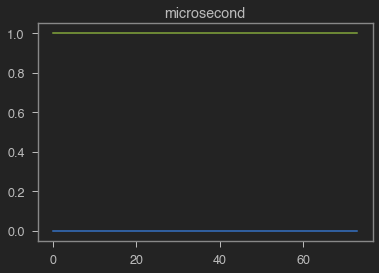

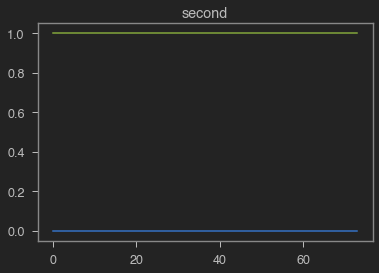

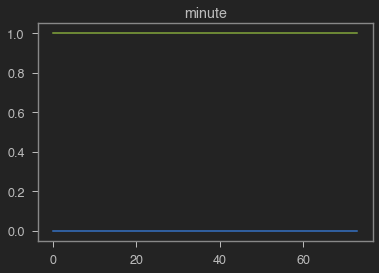

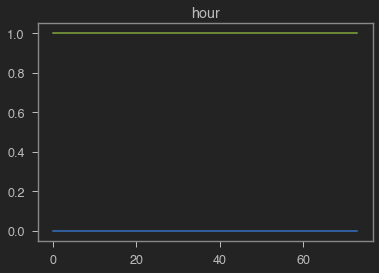

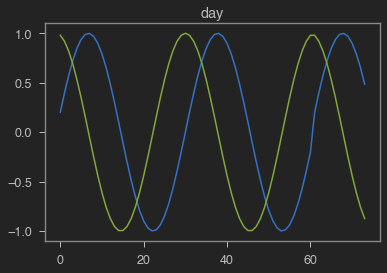

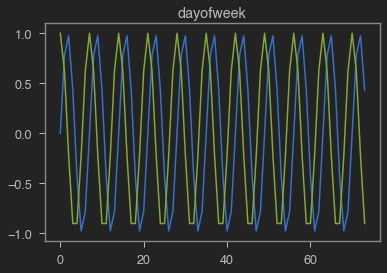

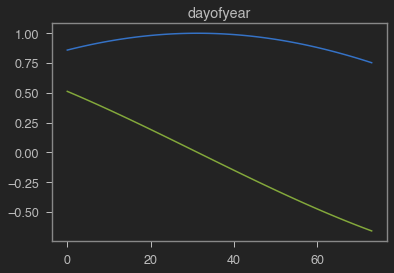

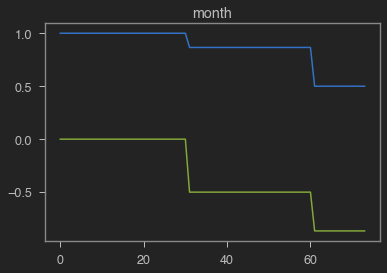

In [ ]:
for freq in ['microsecond', 'second', 'minute', 'hour', 'day', 'dayofweek', 'dayofyear', 'month']:
    tdf = pd.DataFrame(pd.date_range('2021-03-01', datetime.today()), columns=['date'])
    a,b = time_encoding(tdf.date, freq=freq)
    plt.plot(a)
    plt.plot(b)
    plt.title(freq)
    plt.show()

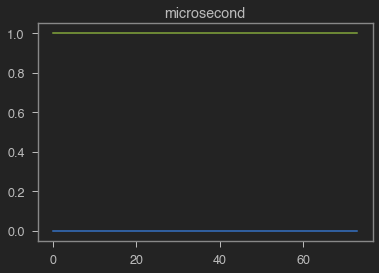

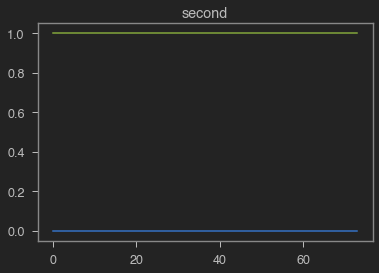

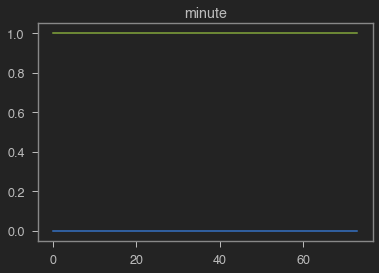

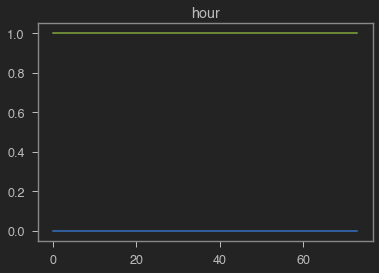

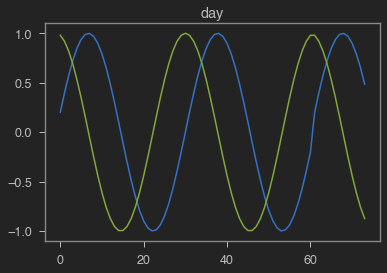

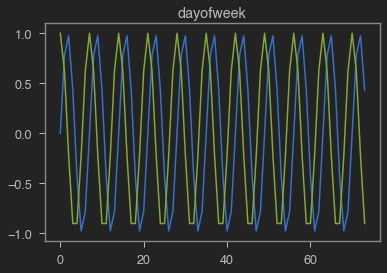

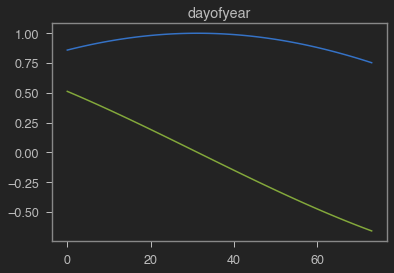

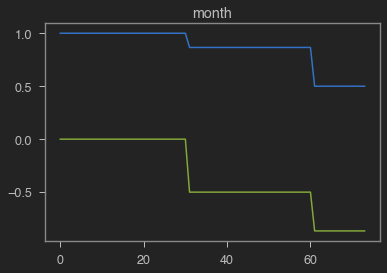

In [ ]:
for freq in ['microsecond', 'second', 'minute', 'hour', 'day', 'dayofweek', 'dayofyear', 'month']:
    dateindex = pd.date_range('2021-03-01', datetime.today())
    a,b = time_encoding(dateindex, freq=freq)
    plt.plot(a)
    plt.plot(b)
    plt.title(freq)
    plt.show()

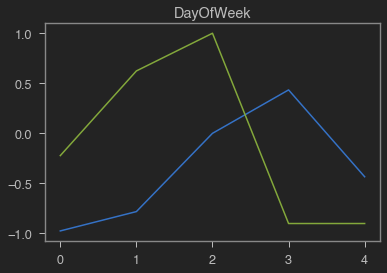

,date,a,b,dow_sin,dow_cos
0,2021-05-01,0.087994,0.0,-0.974928,-0.222521
1,2021-05-02,0.765251,1.0,-0.781831,0.623490
2,2021-05-03,0.296792,0.0,0.000000,1.000000
3,2021-05-06,0.615514,0.0,0.433884,-0.900969
4,2021-05-07,0.013802,1.0,-0.433884,-0.900969


In [ ]:
dow_sin, dow_cos = time_encoding(date_df['date'], 'dayofweek')
plt.plot(dow_sin)
plt.plot(dow_cos)
plt.title('DayOfWeek')
plt.show()
date_df['dow_sin'] = dow_sin
date_df['dow_cos'] = dow_cos
date_df

In [ ]:
# export
def delta_timestamps(data, dir='forward'):
    """Calculates time gaps to the next (forward) or last (backward) mask time steps. 
    This is based on the parse_delta used in:
    Cao, W., Wang, D., Li, J., Zhou, H., Li, L., & Li, Y. (2018). 
    Brits: Bidirectional recurrent imputation for time series. arXiv preprint arXiv:1805.10572.
    """
    assert isinstance(data, pd.core.frame.DataFrame), 'this function can only be used with a pandas dataframe'
    mask = data.isnull().values.astype('float')
    if mask.ndim == 1: mask = mask.reshape(-1, 1)
    n_rows, n_vars = mask.shape
    if dir == 'backward':
        mask = mask[::-1]
    deltas = []
    for h in range(n_rows):
        if h == 0:
            deltas.append(np.ones(n_vars))
        else:
            deltas.append(np.ones(n_vars) + mask[h] * deltas[-1])
    output = np.array(deltas)
    if dir == 'backward':
        output = output[::-1]
    return output

def add_delta_timestamp_cols(df, cols=None, groupby=None, forward=True, backward=True, nearest=True):
    if cols is None: cols = df.columns
    elif not is_listy(cols): cols = [cols]
    if forward or nearest: 
        if groupby:
            forward_time_gaps = np.concatenate(df[cols].groupby(df[groupby]).apply(lambda x: delta_timestamps(x, dir='forward')))
        else: 
            forward_time_gaps = delta_timestamps(df[cols], dir='forward')
        if forward : df[[f'{col}_dt_f' for col in cols]] = forward_time_gaps
    if backward or nearest:
        if groupby:
            backward_time_gaps = np.concatenate(df[cols].groupby(df[groupby]).apply(lambda x: delta_timestamps(x, dir='backward')))
        else:
            backward_time_gaps = delta_timestamps(df[cols], dir='backward')
        if backward: df[[f'{col}_dt_b' for col in cols]] = backward_time_gaps
    if nearest:
        df[[f'{col}_dt_n' for col in cols]] = np.stack([forward_time_gaps, backward_time_gaps]).min(axis=0)
    return df


In [ ]:
date_df = add_missing_timestamps(date_df, 'date', groupby='b')
add_delta_timestamp_cols(date_df, cols='a')

,date,a,b,dow_sin,dow_cos,a_dt_f,a_dt_b,a_dt_n
0,2021-05-01,0.087994,0.0,-0.974928,-0.222521,1.0,1.0,1.0
1,2021-05-02,NaN,0.0,NaN,NaN,2.0,2.0,2.0
2,2021-05-03,0.296792,0.0,0.000000,1.000000,1.0,1.0,1.0
3,2021-05-04,NaN,0.0,NaN,NaN,2.0,3.0,2.0
4,2021-05-05,NaN,0.0,NaN,NaN,3.0,2.0,2.0
5,2021-05-06,0.615514,0.0,0.433884,-0.900969,1.0,1.0,1.0
6,2021-05-02,0.765251,1.0,-0.781831,0.623490,1.0,1.0,1.0
7,2021-05-03,NaN,1.0,NaN,NaN,2.0,5.0,2.0
8,2021-05-04,NaN,1.0,NaN,NaN,3.0,4.0,3.0
9,2021-05-05,NaN,1.0,NaN,NaN,4.0,3.0,3.0


In [ ]:
# export 

# This function is slow!!!
def delta_timestamps_torch(mask, dir='forward'):
    """Calculates time gaps to the next (forward) or last (backward) mask time steps. 
    
    This is based on the parse_delta used in:
    Cao, W., Wang, D., Li, J., Zhou, H., Li, L., & Li, Y. (2018). 
    Brits: Bidirectional recurrent imputation for time series. arXiv preprint arXiv:1805.10572.
    
    Args:
        mask: torch.Tensor with ndim == 3
        dir: 'forward' or 'backward'
    """

    shape = mask.shape
    if dir == 'backward': mask = torch.flip(mask, (-1,))
    mask = mask.reshape(-1, shape[-1], 1)
    n_rows, seq_len, _ = mask.shape
    t_ones = t.new(torch.ones(n_rows).reshape(-1,1))
    deltas = [t_ones]
    for step in range(1, seq_len): 
        deltas.append(t_ones + (mask[:, step-1] * deltas[-1]))
    output = torch.cat(deltas, -1).reshape(shape)
    if dir == 'backward': output = torch.flip(output, (-1,))
    return output

In [ ]:
t = torch.randn(2, 3, 5)
t[t<0] = np.nan
mask = torch.isnan(t)
print(t)
delta_timestamps_torch(mask), delta_timestamps_torch(mask, 'backward')

tensor([[[1.9685,    nan,    nan,    nan, 0.2131],
         [1.1927, 0.3624, 0.4301,    nan,    nan],
         [   nan,    nan,    nan,    nan, 0.6927]],

        [[   nan, 0.5550, 1.2334,    nan,    nan],
         [0.0557, 0.0034, 0.9255, 0.0321,    nan],
         [0.7883, 0.1414, 0.0745,    nan, 0.3251]]])


(tensor([[[1., 1., 2., 3., 4.],
          [1., 1., 1., 1., 2.],
          [1., 2., 3., 4., 5.]],
 
         [[1., 2., 1., 1., 2.],
          [1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 2.]]]),
 tensor([[[4., 3., 2., 1., 1.],
          [1., 1., 3., 2., 1.],
          [4., 3., 2., 1., 1.]],
 
         [[1., 1., 3., 2., 1.],
          [1., 1., 1., 2., 1.],
          [1., 1., 2., 1., 1.]]]))

In [ ]:
#export
# SlidingWindow vectorization is based on "Fast and Robust Sliding Window Vectorization with NumPy" by Syafiq Kamarul Azman
# https://towardsdatascience.com/fast-and-robust-sliding-window-vectorization-with-numpy-3ad950ed62f5


def SlidingWindow(window_len:int, stride:Union[None, int]=1, start:int=0, pad_remainder:bool=False, get_x:Union[None, int, list]=None,
                  get_y:Union[None, int, list]=None, y_func:Optional[callable]=None, horizon:Union[int, list]=1, seq_first:bool=True,
                  sort_by:Optional[list]=None, ascending:bool=True, check_leakage:bool=True):

    """
    Applies a sliding window to a 1d or 2d input (np.ndarray, torch.Tensor or pd.DataFrame)
    Args:
        window_len      = length of lookback window
        stride          = n datapoints the window is moved ahead along the sequence. Default: 1. If None, stride=window_len (no overlap)
        start           = determines the step where the first window is applied: 0 (default), a given step (int), or random within the 1st stride (None).
        pad_remainder   = allows to pad remainder subsequences when the sliding window is applied and get_y == [] (unlabeled data).
        horizon         = number of future datapoints to predict:
                            * 0 for last step in each sub-window.
                            * n > 0 for a range of n future steps (1 to n).
                            * n < 0 for a range of n past steps (-n + 1 to 0).
                            * list : for those exact timesteps.
        get_x           = indices of columns that contain the independent variable (xs). If None, all data will be used as x.
        get_y           = indices of columns that contain the target (ys). If None, all data will be used as y. [] means no y data is created (unlabeled data).
        y_func          = function to calculate the ys based on the get_y col/s and each y sub-window. y_func must be a function applied to axis=1!
        seq_first       = True if input shape (seq_len, n_vars), False if input shape (n_vars, seq_len)
        sort_by         = column/s used for sorting the array in ascending order
        ascending       = used in sorting
        check_leakage   = checks if there's leakage in the output between X and y
    Input:
        You can use np.ndarray, pd.DataFrame or torch.Tensor as input
        shape: (seq_len, ) or (seq_len, n_vars) if seq_first=True else (n_vars, seq_len)
    """

    if horizon == 0: horizon_rng = np.array([0])
    elif is_listy(horizon): horizon_rng = np.array(horizon)
    elif isinstance(horizon, Integral): horizon_rng = np.arange(1, horizon + 1) if horizon > 0 else np.arange(horizon + 1, 1)
    min_horizon = min(horizon_rng)
    max_horizon = max(horizon_rng)
    _get_x = slice(None) if get_x is None else get_x.tolist() if isinstance(get_x, pd.core.indexes.base.Index) else [get_x] if not is_listy(get_x) else get_x
    _get_y = slice(None) if get_y is None else get_y.tolist() if isinstance(get_y, pd.core.indexes.base.Index) else [get_y] if not is_listy(get_y) else get_y
    if min_horizon <= 0 and y_func is None and get_y != [] and check_leakage:
        assert get_x is not None and  get_y is not None and len([y for y in _get_y if y in _get_x]) == 0,  \
        'you need to change either horizon, get_x, get_y or use a y_func to avoid leakage'
    stride = ifnone(stride, window_len)

    def _inner(o):
        if not seq_first: o = o.T
        if isinstance(o, pd.DataFrame):
            if sort_by is not None: o.sort_values(by=sort_by, axis=0, ascending=ascending, inplace=True, ignore_index=True)
            X = o.loc[:, _get_x].values if get_x is None or not isinstance(_get_x[0], Integral) else o.iloc[:, _get_x].values
            if get_y != []: y = o.loc[:, _get_y].values if get_y is None or not isinstance(_get_y[0], Integral) else o.iloc[:, _get_y].values
        else:
            if isinstance(o, torch.Tensor): o = o.numpy()
            if o.ndim < 2: o = o[:, None]
            X = o[:, _get_x]
            if get_y != []: y = o[:, _get_y]
        seq_len = len(X)
        if get_y != []: 
            X_max_time = seq_len - start - max_horizon - window_len
        else: 
            X_max_time = seq_len - start - window_len
        if X_max_time <= 0: return None, None
        if get_y == [] and pad_remainder and X_max_time % stride:
            X_max_time = X_max_time - X_max_time % stride + stride
            _X = np.empty((window_len + start + X_max_time - len(X), *X.shape[1:]))
            _X[:] = np.nan
            X = np.concatenate((X, _X))
        X_sub_windows = (start +
                         np.expand_dims(np.arange(window_len), 0) + # window len
                         np.expand_dims(np.arange(X_max_time + 1, step=stride), 0).T) # # subwindows
        X = np.transpose(X[X_sub_windows], (0, 2, 1))
        if get_y != [] and y is not None:
            y_start = start + window_len - 1
            y_max_time = seq_len - y_start - max_horizon
            y_sub_windows = (y_start +
                             np.expand_dims(horizon_rng, 0) + # horizon_rng
                             np.expand_dims(np.arange(y_max_time, step=stride), 0).T) # # subwindows
            y = y[y_sub_windows]
            if y_func is not None and len(y) > 0:
                y = y_func(y)
            if y.ndim >= 2:
                for d in np.arange(1, y.ndim)[::-1]:
                    if y.shape[d] == 1: y = np.squeeze(y, axis=d)
            if y.ndim == 3:
                y = y.transpose(0, 2, 1)
            return X, y
        else: return X, None
    return _inner

SlidingWindowSplitter = SlidingWindow

In [ ]:
wl = 5
stride = 5

t = np.repeat(np.arange(13).reshape(-1,1), 3, axis=-1)
print('input shape:', t.shape)
X, y = SlidingWindow(wl, stride=stride, pad_remainder=True, get_y=[])(t)
X

input shape: (13, 3)


array([[[ 0.,  1.,  2.,  3.,  4.],
        [ 0.,  1.,  2.,  3.,  4.],
        [ 0.,  1.,  2.,  3.,  4.]],

       [[ 5.,  6.,  7.,  8.,  9.],
        [ 5.,  6.,  7.,  8.,  9.],
        [ 5.,  6.,  7.,  8.,  9.]],

       [[10., 11., 12., nan, nan],
        [10., 11., 12., nan, nan],
        [10., 11., 12., nan, nan]]])

In [ ]:
wl = 5
t = np.arange(10)
print('input shape:', t.shape)
X, y = SlidingWindow(wl)(t)
test_eq(X.shape[1:], (1, wl))
itemify(X,)

input shape: (10,)


(#5) [(array([[0, 1, 2, 3, 4]]),),(array([[1, 2, 3, 4, 5]]),),(array([[2, 3, 4, 5, 6]]),),(array([[3, 4, 5, 6, 7]]),),(array([[4, 5, 6, 7, 8]]),)]

In [ ]:
wl = 5
h = 1

t = np.arange(10)
print('input shape:', t.shape)
X, y = SlidingWindow(wl, stride=1, horizon=h)(t)
items = itemify(X, y)
print(items)
test_eq(items[0][0].shape, (1, wl))
test_eq(items[0][1].shape, ())

input shape: (10,)
[(array([[0, 1, 2, 3, 4]]), 5), (array([[1, 2, 3, 4, 5]]), 6), (array([[2, 3, 4, 5, 6]]), 7), (array([[3, 4, 5, 6, 7]]), 8), (array([[4, 5, 6, 7, 8]]), 9)]


In [ ]:
wl = 5
h = 2 # 2 or more

t = np.arange(10)
print('input shape:', t.shape)
X, y = SlidingWindow(wl, horizon=h)(t)
items = itemify(X, y)
print(items)
test_eq(items[0][0].shape, (1, wl))
test_eq(items[0][1].shape, (2, ))

input shape: (10,)
[(array([[0, 1, 2, 3, 4]]), array([5, 6])), (array([[1, 2, 3, 4, 5]]), array([6, 7])), (array([[2, 3, 4, 5, 6]]), array([7, 8])), (array([[3, 4, 5, 6, 7]]), array([8, 9]))]


In [ ]:
wl = 5
h = 2 # 2 or more

t = np.arange(10).reshape(1, -1)
print('input shape:', t.shape)
X, y = SlidingWindow(wl, stride=1, horizon=h, get_y=None, seq_first=False)(t)
items = itemify(X, y)
print(items)
test_eq(items[0][0].shape, (1, wl))
test_eq(items[0][1].shape, (2, ))

input shape: (1, 10)
[(array([[0, 1, 2, 3, 4]]), array([5, 6])), (array([[1, 2, 3, 4, 5]]), array([6, 7])), (array([[2, 3, 4, 5, 6]]), array([7, 8])), (array([[3, 4, 5, 6, 7]]), array([8, 9]))]


In [ ]:
wl = 5
h = 2 # 2 or more

t = np.arange(10).reshape(1, -1)
print('input shape:', t.shape)
X, y = SlidingWindow(wl, stride=1, horizon=h, seq_first=False)(t)
items = itemify(X, y)
print(items)
test_eq(items[0][0].shape, (1, wl))

input shape: (1, 10)
[(array([[0, 1, 2, 3, 4]]), array([5, 6])), (array([[1, 2, 3, 4, 5]]), array([6, 7])), (array([[2, 3, 4, 5, 6]]), array([7, 8])), (array([[3, 4, 5, 6, 7]]), array([8, 9]))]


In [ ]:
wl = 5

t = np.arange(10).reshape(1, -1)
print('input shape:', t.shape)
X, y = SlidingWindow(wl, stride=3, horizon=1, get_y=None, seq_first=False)(t)
items = itemify(X, y)
print(items)
test_eq(items[0][0].shape, (1, wl))
test_eq(items[0][1].shape, ())

input shape: (1, 10)
[(array([[0, 1, 2, 3, 4]]), 5), (array([[3, 4, 5, 6, 7]]), 8)]


In [ ]:
wl = 5
start = 3

t = np.arange(20)
print('input shape:', t.shape)
X, y = SlidingWindow(wl, stride=None, horizon=1, start=start)(t)
items = itemify(X, y)
print(items)
test_eq(items[0][0].shape, (1, wl))
test_eq(items[0][1].shape, ())

input shape: (20,)
[(array([[3, 4, 5, 6, 7]]), 8), (array([[ 8,  9, 10, 11, 12]]), 13), (array([[13, 14, 15, 16, 17]]), 18)]


In [ ]:
wl = 5

t = np.arange(20)
print('input shape:', t.shape)
df = pd.DataFrame(t, columns=['var'])
display(df)
X, y = SlidingWindow(wl, stride=None, horizon=1, get_y=None)(df)
items = itemify(X, y)
print(items)
test_eq(items[0][0].shape, (1, wl))
test_eq(items[0][1].shape, ())

input shape: (20,)


,var
0,0
1,1
2,2
3,3
4,4
5,5
6,6
7,7
8,8
9,9


[(array([[0, 1, 2, 3, 4]]), 5), (array([[5, 6, 7, 8, 9]]), 10), (array([[10, 11, 12, 13, 14]]), 15)]


In [ ]:
wl = 5

t = np.arange(20)
print('input shape:', t.shape)
df = pd.DataFrame(t, columns=['var'])
display(df)
X, y = SlidingWindow(wl, stride=1, horizon=1, get_y=None)(df)
items = itemify(X, y)
print(items)
test_eq(items[0][0].shape, (1, wl))
test_eq(items[0][1].shape, ())

input shape: (20,)


,var
0,0
1,1
2,2
3,3
4,4
5,5
6,6
7,7
8,8
9,9


[(array([[0, 1, 2, 3, 4]]), 5), (array([[1, 2, 3, 4, 5]]), 6), (array([[2, 3, 4, 5, 6]]), 7), (array([[3, 4, 5, 6, 7]]), 8), (array([[4, 5, 6, 7, 8]]), 9), (array([[5, 6, 7, 8, 9]]), 10), (array([[ 6,  7,  8,  9, 10]]), 11), (array([[ 7,  8,  9, 10, 11]]), 12), (array([[ 8,  9, 10, 11, 12]]), 13), (array([[ 9, 10, 11, 12, 13]]), 14), (array([[10, 11, 12, 13, 14]]), 15), (array([[11, 12, 13, 14, 15]]), 16), (array([[12, 13, 14, 15, 16]]), 17), (array([[13, 14, 15, 16, 17]]), 18), (array([[14, 15, 16, 17, 18]]), 19)]


In [ ]:
wl = 5

t = np.arange(20)
print('input shape:', t.shape)
df = pd.DataFrame(t, columns=['var']).T
display(df)
X, y = SlidingWindow(wl, stride=None, horizon=1, get_y=None, seq_first=False)(df)
items = itemify(X, y)
print(items)
test_eq(items[0][0].shape, (1, wl))
test_eq(items[0][1].shape, ())

input shape: (20,)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
var,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19


[(array([[0, 1, 2, 3, 4]]), 5), (array([[5, 6, 7, 8, 9]]), 10), (array([[10, 11, 12, 13, 14]]), 15)]


In [ ]:
wl = 5
n_vars = 3

t = (torch.stack(n_vars * [torch.arange(10)]).T * tensor([1, 10, 100]))
print('input shape:', t.shape)
df = pd.DataFrame(t, columns=[f'var_{i}' for i in range(n_vars)])
display(df)
X, y = SlidingWindow(wl, horizon=1)(df)
items = itemify(X, y)
print(items)
test_eq(items[0][0].shape, (n_vars, wl))

input shape: torch.Size([10, 3])


,var_0,var_1,var_2
0,0,0,0
1,1,10,100
2,2,20,200
3,3,30,300
4,4,40,400
5,5,50,500
6,6,60,600
7,7,70,700
8,8,80,800
9,9,90,900


[(array([[  0,   1,   2,   3,   4],
       [  0,  10,  20,  30,  40],
       [  0, 100, 200, 300, 400]]), array([  5,  50, 500])), (array([[  1,   2,   3,   4,   5],
       [ 10,  20,  30,  40,  50],
       [100, 200, 300, 400, 500]]), array([  6,  60, 600])), (array([[  2,   3,   4,   5,   6],
       [ 20,  30,  40,  50,  60],
       [200, 300, 400, 500, 600]]), array([  7,  70, 700])), (array([[  3,   4,   5,   6,   7],
       [ 30,  40,  50,  60,  70],
       [300, 400, 500, 600, 700]]), array([  8,  80, 800])), (array([[  4,   5,   6,   7,   8],
       [ 40,  50,  60,  70,  80],
       [400, 500, 600, 700, 800]]), array([  9,  90, 900]))]


In [ ]:
wl = 5
n_vars = 3

t = (torch.stack(n_vars * [torch.arange(10)]).T * tensor([1, 10, 100]))
print('input shape:', t.shape)
df = pd.DataFrame(t, columns=[f'var_{i}' for i in range(n_vars)])
display(df)
X, y = SlidingWindow(wl, horizon=1, get_y=0)(df)
items = itemify(X, y)
print(items)
test_eq(items[0][0].shape, (n_vars, wl))

input shape: torch.Size([10, 3])


,var_0,var_1,var_2
0,0,0,0
1,1,10,100
2,2,20,200
3,3,30,300
4,4,40,400
5,5,50,500
6,6,60,600
7,7,70,700
8,8,80,800
9,9,90,900


[(array([[  0,   1,   2,   3,   4],
       [  0,  10,  20,  30,  40],
       [  0, 100, 200, 300, 400]]), 5), (array([[  1,   2,   3,   4,   5],
       [ 10,  20,  30,  40,  50],
       [100, 200, 300, 400, 500]]), 6), (array([[  2,   3,   4,   5,   6],
       [ 20,  30,  40,  50,  60],
       [200, 300, 400, 500, 600]]), 7), (array([[  3,   4,   5,   6,   7],
       [ 30,  40,  50,  60,  70],
       [300, 400, 500, 600, 700]]), 8), (array([[  4,   5,   6,   7,   8],
       [ 40,  50,  60,  70,  80],
       [400, 500, 600, 700, 800]]), 9)]


In [ ]:
wl = 5
n_vars = 3

t = (torch.stack(n_vars * [torch.arange(10)]).T * tensor([1, 10, 100]))
print('input shape:', t.shape)
columns=[f'var_{i}' for i in range(n_vars-1)]+['target']
df = pd.DataFrame(t, columns=columns)
display(df)
X, y = SlidingWindow(wl, horizon=1, get_x=columns[:-1], get_y='target')(df)
items = itemify(X, y)
print(items)
test_eq(items[0][0].shape, (n_vars-1, wl))
test_eq(items[0][1].shape, ())

input shape: torch.Size([10, 3])


,var_0,var_1,target
0,0,0,0
1,1,10,100
2,2,20,200
3,3,30,300
4,4,40,400
5,5,50,500
6,6,60,600
7,7,70,700
8,8,80,800
9,9,90,900


[(array([[ 0,  1,  2,  3,  4],
       [ 0, 10, 20, 30, 40]]), 500), (array([[ 1,  2,  3,  4,  5],
       [10, 20, 30, 40, 50]]), 600), (array([[ 2,  3,  4,  5,  6],
       [20, 30, 40, 50, 60]]), 700), (array([[ 3,  4,  5,  6,  7],
       [30, 40, 50, 60, 70]]), 800), (array([[ 4,  5,  6,  7,  8],
       [40, 50, 60, 70, 80]]), 900)]


(1000, 3)


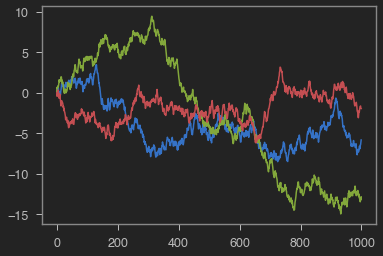

(200, 2, 5) (200,)


In [ ]:
n_vars = 3

t = (np.random.rand(1000, n_vars) - .5).cumsum(0)
print(t.shape)
plt.plot(t)
plt.show()
X, y = SlidingWindow(5, stride=None, horizon=0, get_x=[0,1], get_y=2)(t)
test_eq(X[0].shape, (n_vars-1, wl))
test_eq(y[0].shape, ())
print(X.shape, y.shape)

In [ ]:
wl = 5
n_vars = 3

t = (np.random.rand(100, n_vars) - .5).cumsum(0)
print(t.shape)
columns=[f'var_{i}' for i in range(n_vars-1)]+['target']
df = pd.DataFrame(t, columns=columns)
display(df)
X, y = SlidingWindow(5, horizon=0, get_x=columns[:-1], get_y='target')(df)
test_eq(X[0].shape, (n_vars-1, wl))
test_eq(y[0].shape, ())
print(X.shape, y.shape)

(100, 3)


,var_0,var_1,target
0,-0.287726,-0.178106,0.418652
1,-0.167130,-0.479855,0.033680
2,0.235744,-0.067876,0.296558
3,0.582813,-0.174497,0.539710
4,0.368983,-0.076861,0.886567
...,...,...,...
95,1.060305,2.223662,1.686774
96,0.570424,2.391226,1.296574
97,1.020865,2.116284,1.263844
98,1.258792,1.658256,1.320597


(96, 2, 5) (96,)


In [ ]:
seq_len = 100
n_vars = 5
t = (np.random.rand(seq_len, n_vars) - .5).cumsum(0)
print(t.shape)
columns=[f'var_{i}' for i in range(n_vars-1)]+['target']
df = pd.DataFrame(t, columns=columns)
display(df)
X, y = SlidingWindow(5, stride=1, horizon=0, get_x=columns[:-1], get_y='target', seq_first=True)(df)
test_eq(X[0].shape, (n_vars-1, wl))
test_eq(y[0].shape, ())
print(X.shape, y.shape)

(100, 5)


,var_0,var_1,var_2,var_3,target
0,0.286904,-0.213878,0.466979,-0.082688,0.467299
1,0.593815,-0.408195,0.778438,-0.506048,0.464978
2,0.150130,-0.249390,0.817302,-0.125355,0.454443
3,0.295709,-0.459654,0.509966,-0.220609,0.845064
4,0.605448,-0.790329,0.333572,-0.298086,1.107788
...,...,...,...,...,...
95,1.441206,-5.932946,-2.070561,-4.443138,0.519666
96,1.303583,-5.952226,-1.682497,-3.948945,0.454500
97,1.371060,-6.253976,-1.449480,-4.193574,0.867069
98,1.716472,-6.235683,-1.851925,-4.459444,1.360535


(96, 4, 5) (96,)


In [ ]:
seq_len = 100
n_vars = 5

t = (np.random.rand(seq_len, n_vars) - .5).cumsum(0)
print(t.shape)
columns=[f'var_{i}' for i in range(n_vars-1)] + ['target']
df = pd.DataFrame(t, columns=columns).T
display(df)
X, y = SlidingWindow(5, stride=1, horizon=0, get_x=columns[:-1], get_y='target', seq_first=False)(df)
test_eq(X[0].shape, (n_vars-1, wl))
test_eq(y[0].shape, ())
print(X.shape, y.shape)

(100, 5)


,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
var_0,-0.344156,-0.622920,-1.102148,-1.209541,-1.290659,-0.930502,-0.471472,-0.745313,-1.176582,-1.229829,...,-2.673580,-2.504219,-2.384536,-2.418048,-2.414210,-2.593896,-2.255339,-2.038135,-1.919185,-1.720302
var_1,0.093268,0.254239,-0.129421,0.216370,-0.244368,0.040269,0.125281,0.130227,0.157236,0.061658,...,0.116295,-0.059324,-0.112654,0.001759,-0.410288,-0.642449,-1.124305,-0.759327,-1.090020,-0.907065
var_2,-0.328626,-0.588135,-0.883439,-0.867334,-1.210488,-1.204266,-0.759232,-0.423418,-0.203920,-0.576036,...,1.695425,1.364037,1.487373,1.891720,2.048806,2.054982,2.372379,2.861048,3.277938,2.806800
var_3,-0.341567,-0.507151,-0.264903,0.117015,0.128558,-0.100532,0.224692,0.233865,-0.075485,0.272478,...,2.290851,2.371111,2.494858,2.362474,2.661276,2.776975,2.616571,3.079344,2.994094,2.907047
target,0.083450,0.055454,-0.327549,-0.079720,-0.562719,-0.241909,-0.107584,-0.531088,-0.095397,-0.258910,...,-3.490661,-3.857740,-4.118911,-3.627084,-4.092928,-4.222835,-4.429502,-4.629132,-4.269901,-3.961920


(96, 4, 5) (96,)


In [ ]:
seq_len = 100
n_vars = 5
t = (np.random.rand(seq_len, n_vars) - .5).cumsum(0)
print(t.shape)
columns=[f'var_{i}' for i in range(n_vars-1)] + ['target']
df = pd.DataFrame(t, columns=columns).T
display(df)
X, y = SlidingWindow(5, stride=None, horizon=0, get_x=columns[:-1], get_y='target', seq_first=False)(df)
test_eq(X[0].shape, (n_vars-1, wl))
test_eq(y[0].shape, ())
print(X.shape, y.shape)

(100, 5)


,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
var_0,-0.156331,-0.655100,-1.111205,-1.373211,-0.878892,-0.765050,-0.564909,-0.536671,-0.202294,-0.259602,...,2.110042,2.467771,2.934763,3.191256,3.323044,3.718613,3.220607,3.620633,3.727377,3.655074
var_1,0.147746,-0.306375,-0.581003,-0.788980,-0.347802,-0.707820,-0.587332,-0.108651,-0.180365,-0.378667,...,-2.464790,-2.391267,-2.414635,-2.568924,-2.568195,-2.659978,-2.944527,-2.561174,-2.733221,-2.684688
var_2,0.401699,0.278739,0.168258,0.226481,0.392406,0.180373,-0.015092,0.036469,0.409182,0.040333,...,-1.802500,-1.600578,-1.134254,-0.989537,-1.222702,-1.279126,-1.704694,-1.304530,-0.924099,-1.058708
var_3,-0.122310,-0.241578,-0.099142,-0.323762,-0.728096,-0.601289,-1.047889,-1.445212,-1.549292,-1.851672,...,-1.155223,-0.847903,-0.544514,-0.230209,-0.352256,-0.632232,-0.831822,-1.212788,-1.214648,-1.314000
target,0.007582,-0.111092,-0.336502,0.114295,0.514138,0.747305,0.894017,0.786445,0.743829,0.920710,...,0.337333,-0.114448,-0.462885,-0.109223,0.363431,0.042377,0.457124,0.024447,0.305369,0.370886


(20, 4, 5) (20,)


In [ ]:
seq_len = 100
n_vars = 5
t = (np.random.rand(seq_len, n_vars) - .5).cumsum(0)
print(t.shape)
columns=[f'var_{i}' for i in range(n_vars-1)]+['target']
df = pd.DataFrame(t, columns=columns)
display(df)
X, y = SlidingWindow(5, stride=1, horizon=0, get_x=columns[:-1], get_y='target', seq_first=True)(df)
splits = TrainValidTestSplitter(valid_size=.2, shuffle=False)(y)
X.shape, y.shape, splits

(100, 5)


,var_0,var_1,var_2,var_3,target
0,-0.083431,-0.279623,-0.090247,-0.079336,-0.417207
1,-0.407012,-0.072210,-0.223443,-0.289659,0.080252
2,-0.541435,0.139514,-0.657185,-0.743425,0.111154
3,-0.328088,0.278511,-0.404022,-0.781462,-0.013523
4,0.011824,0.370582,-0.138363,-0.690534,0.339398
...,...,...,...,...,...
95,-2.992645,0.717409,-4.759399,-2.066841,0.311698
96,-2.572909,0.841158,-4.335901,-2.230841,0.223483
97,-2.353266,0.772864,-4.595175,-2.043060,0.264541
98,-2.102483,0.300780,-4.636680,-2.008941,0.697816


((96, 4, 5),
 (96,),
 ((#77) [0,1,2,3,4,5,6,7,8,9...], (#19) [77,78,79,80,81,82,83,84,85,86...]))

In [ ]:
#export
def SlidingWindowPanel(window_len:int, unique_id_cols:list, stride:Union[None, int]=1, start:int=0, pad_remainder:bool=False, 
                       get_x:Union[None, int, list]=None,  get_y:Union[None, int, list]=None, y_func:Optional[callable]=None, 
                       horizon:Union[int, list]=1, seq_first:bool=True, sort_by:Optional[list]=None, ascending:bool=True, 
                       check_leakage:bool=True, return_key:bool=False, verbose:bool=True):

    """
    Applies a sliding window to a pd.DataFrame.
    
    Args:
        window_len      = length of lookback window
        unique_id_cols  = pd.DataFrame columns that will be used to identify a time series for each entity.
        stride          = n datapoints the window is moved ahead along the sequence. Default: 1. If None, stride=window_len (no overlap)
        start           = determines the step where the first window is applied: 0 (default), a given step (int), or random within the 1st stride (None). 
        pad_remainder   = allows to pad remainder subsequences when the sliding window is applied and get_y == [] (unlabeled data).
        horizon         = number of future datapoints to predict:
                            * 0 for last step in each sub-window. 
                            * n > 0 for a range of n future steps (1 to n). 
                            * n < 0 for a range of n past steps (-n + 1 to 0).
                            * list : for those exact timesteps.
        get_x           = indices of columns that contain the independent variable (xs). If None, all data will be used as x.
        get_y           = indices of columns that contain the target (ys). If None, all data will be used as y. [] means no y data is created (unlabeled data).
        y_func          = function to calculate the ys based on the get_y col/s and each y sub-window. y_func must be a function applied to axis=1!
        seq_first       = True if input shape (seq_len, n_vars), False if input shape (n_vars, seq_len)
        sort_by         = column/s used for sorting the array in ascending order
        ascending       = used in sorting
        check_leakage   = checks if there's leakage in the output between X and y
        return_key      = when True, the key corresponsing to unique_id_cols for each sample is returned
        verbose         = controls verbosity. True or 1 displays progress bar. 2 or more show records that cannot be created due to its length.
        
        
    Input:
        You can use np.ndarray, pd.DataFrame or torch.Tensor as input
        shape: (seq_len, ) or (seq_len, n_vars) if seq_first=True else (n_vars, seq_len)
    """
    
    if not is_listy(unique_id_cols): unique_id_cols = [unique_id_cols]
    if sort_by is not None and not  is_listy(sort_by): sort_by = [sort_by]
    sort_by = unique_id_cols + (sort_by if sort_by is not None else [])
    
    def _SlidingWindowPanel(df):
        
        df.sort_values(by=sort_by, axis=0, ascending=ascending, inplace=True, ignore_index=True)
        unique_id_values = df[unique_id_cols].drop_duplicates().values
        _x = []
        _y = []
        _key = []
        for v in progress_bar(unique_id_values, display=verbose, leave=False):
            x_v, y_v = SlidingWindow(window_len, stride=stride, start=start, pad_remainder=pad_remainder, get_x=get_x, get_y=get_y, y_func=y_func, 
                                     horizon=horizon, seq_first=seq_first, 
                                     check_leakage=check_leakage)(df[(df[unique_id_cols].values == v).sum(axis=1) == len(v)])                                
            if x_v is not None and len(x_v) > 0: 
                _x.append(x_v)
                if return_key: _key.append([v.tolist()] * len(x_v))
                if y_v is not None and len(y_v) > 0: _y.append(y_v)
            elif verbose>=2: 
                print(f'cannot use {unique_id_cols} = {v} due to not having enough records')

        X = np.concatenate(_x)
        if _y != []:
            y = np.concatenate(_y)
            for d in np.arange(1, y.ndim)[::-1]:
                if y.shape[d] == 1: y = np.squeeze(y, axis=d)
        else: y = None
        if return_key: 
            key = np.concatenate(_key)
            if key.ndim == 2 and key.shape[-1] == 1: key = np.squeeze(key, -1)
            if return_key: return X, y, key
        else: return X, y
        
    return _SlidingWindowPanel

SlidingWindowPanelSplitter = SlidingWindowPanel

In [ ]:
samples = 100_000
wl = 5
n_vars = 10

t = (torch.stack(n_vars * [torch.arange(samples)]).T * tensor([10**i for i in range(n_vars)]))
df = pd.DataFrame(t, columns=[f'var_{i}' for i in range(n_vars)])
df['time'] = np.arange(len(t))
df['device'] = 0
df['target'] = np.random.randint(0, 2, len(df))
df2 = df.copy()
df3 = df.copy()
cols = ['var_0', 'var_1', 'var_2', 'device', 'target']
df2[cols] = df2[cols] + 1
df3[cols] = df3[cols] + 2
df2 = df2.loc[:3]
df['region'] = 'A'
df2['region'] = 'A'
df3['region'] = 'B'
df = df.append(df2).append(df3).reset_index(drop=True)
df['index'] = np.arange(len(df))
df = df.sample(frac=1).reset_index(drop=True)
display(df.head())
df.shape

,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,time,device,target,region,index
0,28185,281850,2818500,28185000,281850000,2818500000,28185000000,281850000000,2818500000000,28185000000000,28185,0,1,A,28185
1,92766,927642,9276402,92764000,927640000,9276400000,92764000000,927640000000,9276400000000,92764000000000,92764,2,2,B,192768
2,67069,670672,6706702,67067000,670670000,6706700000,67067000000,670670000000,6706700000000,67067000000000,67067,2,2,B,167071
3,30484,304822,3048202,30482000,304820000,3048200000,30482000000,304820000000,3048200000000,30482000000000,30482,2,2,B,130486
4,52930,529282,5292802,52928000,529280000,5292800000,52928000000,529280000000,5292800000000,52928000000000,52928,2,3,B,152932


(200004, 15)

In [ ]:
X, y = SlidingWindowPanel(window_len=5, unique_id_cols=['device'], stride=1, start=0, get_x=df.columns[:n_vars], get_y=['target'], 
                          horizon=0, seq_first=True, sort_by=['time'], ascending=True, return_key=False)(df)
X.shape, y.shape

((199992, 10, 5), (199992,))

In [ ]:
X, y, key = SlidingWindowPanel(window_len=5, unique_id_cols=['device'], stride=1, start=0, get_x=df.columns[:n_vars], get_y=['target'], 
                               horizon=0, seq_first=True, sort_by=['time'], ascending=True, return_key=True)(df)
X.shape, y.shape, key.shape

((199992, 10, 5), (199992,), (199992,))

In [ ]:
X, y = SlidingWindowPanel(window_len=5, unique_id_cols=['device', 'region'], stride=1, start=0, get_x=df.columns[:n_vars], get_y=['target'], 
                          horizon=0, seq_first=True, sort_by=['time'], ascending=True)(df)
X.shape, y.shape

((199992, 10, 5), (199992,))

In [ ]:
# y_func must be a function applied to axis=1!
def y_max(o): return np.max(o, axis=1)

In [ ]:
X, y = SlidingWindowPanel(window_len=5, unique_id_cols=['device', 'region'], stride=1, start=0, get_x=df.columns[:n_vars], get_y=['target'], 
                          y_func=y_max, horizon=5, seq_first=True, sort_by=['time'], ascending=True)(df)
X.shape, y.shape

((199982, 10, 5), (199982,))

In [ ]:
# export

def identify_padding(float_mask, value=-1):
    """Identifies padded subsequences in a mask of type float
    
    This function identifies as padded subsequences those where all values == nan 
    from the end of the sequence (last dimension) across all channels, and sets
    those values to the selected value (default = -1)
    
    Args:
        mask: boolean or float mask
        value: scalar that will be used to identify padded subsequences 
    """
    padding = torch.argmax((torch.flip(float_mask.mean((1)) - 1, (-1,)) != 0).float(), -1)
    padded_idxs = torch.arange(len(float_mask))[padding != 0]
    if len(padded_idxs) > 0:
        padding = padding[padding != 0]
        for idx,pad in zip(padded_idxs, padding): float_mask[idx, :, -pad:] = value
    return float_mask

In [ ]:
wl = 5
stride = 5

t = np.repeat(np.arange(13).reshape(-1,1), 3, axis=-1)
print('input shape:', t.shape)
X, _ = SlidingWindow(wl, stride=stride, pad_remainder=True, get_y=[])(t)
X = tensor(X)
X[0, 1, -2:] = np.nan
X[1,..., :3] = np.nan
print(X)
identify_padding(torch.isnan(X).float())

input shape: (13, 3)
tensor([[[ 0.,  1.,  2.,  3.,  4.],
         [ 0.,  1.,  2., nan, nan],
         [ 0.,  1.,  2.,  3.,  4.]],

        [[nan, nan, nan,  8.,  9.],
         [nan, nan, nan,  8.,  9.],
         [nan, nan, nan,  8.,  9.]],

        [[10., 11., 12., nan, nan],
         [10., 11., 12., nan, nan],
         [10., 11., 12., nan, nan]]])


tensor([[[ 0.,  0.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  1.,  1.],
         [ 0.,  0.,  0.,  0.,  0.]],

        [[ 1.,  1.,  1.,  0.,  0.],
         [ 1.,  1.,  1.,  0.,  0.],
         [ 1.,  1.,  1.,  0.,  0.]],

        [[ 0.,  0.,  0., -1., -1.],
         [ 0.,  0.,  0., -1., -1.],
         [ 0.,  0.,  0., -1., -1.]]])

In [ ]:
#hide
out = create_scripts(); beep(out)

<IPython.core.display.Javascript object>

Converted 000_utils.ipynb.
Converted 000b_data.validation.ipynb.
Converted 000c_data.preparation.ipynb.
Converted 001_data.external.ipynb.
Converted 002_data.core.ipynb.
Converted 002b_data.unwindowed.ipynb.
Converted 002c_data.metadatasets.ipynb.
Converted 003_data.preprocessing.ipynb.
Converted 003b_data.transforms.ipynb.
Converted 003c_data.mixed_augmentation.ipynb.
Converted 003d_data.image.ipynb.
Converted 003e_data.features.ipynb.
Converted 005_data.tabular.ipynb.
Converted 006_data.mixed.ipynb.
Converted 051_metrics.ipynb.
Converted 052_learner.ipynb.
Converted 052b_tslearner.ipynb.
Converted 053_optimizer.ipynb.
Converted 060_callback.core.ipynb.
Converted 061_callback.noisy_student.ipynb.
Converted 062_callback.gblend.ipynb.
Converted 063_callback.MVP.ipynb.
Converted 064_callback.PredictionDynamics.ipynb.
Converted 100_models.layers.ipynb.
Converted 100b_models.utils.ipynb.
Converted 100c_models.explainability.ipynb.
Converted 101_models.ResNet.ipynb.
Converted 101b_models.Re